<a href="https://colab.research.google.com/github/JuanPabloArmas/DeepLearningWorkshop/blob/main/HW_1_JPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# initialize the seeds of different random number generators so that the
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

<font color='red'> **Please be sure to make a copy of this notebook on your own Google Drive so that your work is saved!** </font>

In [ ]:
!wget -q -O fer2013.csv -P ./ https://dl.dropbox.com/scl/fi/e2ik6aryemboameq1rwwn/fer2013.csv?rlkey=ux7tyge6flk9nnuul9desizgf&dl=0

The data has 35887 rows and 3 columns:
* Emotion - encoded as the numbers 0 (anger) through 6 (neutral)
* Pixels - A space-separated list of numbers representing the pixels of this image.
* Usage - No need to worry about this column

In [ ]:
data = pd.read_csv('fer2013.csv')
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


The pixel values for each image is provided as a space-separated list of numbers. How many pixels in an image?

In [ ]:
len(data.loc[0, 'pixels'].split(' '))

2304

### Pre-Processing the Pixels (Independent Variable)

Each image is encoded as a list of 2304 pixels. We will reshape this into an 48x48 image next.

Recall that a color image is represented as a tensor of dimension N by M by 3, where the 3 represents the 3 color channels (red, green and blue). Our images from the FER 2013 dataset are grayscale images, with only a single channel representing the amount of black in the image. This is inconvenient to work with because many pre-trained models used in transfer learning, such as the one we will use in Problem 4, require the input image to have 3 channels.

To get around this, we will take each image, a 48 x 48 tensor and transform it into a 48 x 48 x 3 tensor by simply duplicating it three times. We can think of a greyscale image is one where the red, green and blue color channels are exactly the same.

The following code transforms our dataset into a tensor of shape (35887, 48, 48, 3): a list of 35887 images, each of which are a (48, 48, 3)-shape tensor.

In [ ]:
pixels = data['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')] # read each face as a 1-d array
    face = np.asarray(face).reshape(width, height) # reshape the length 2304 1-d array into an 48x48 array
    face = np.stack((face,)*3, axis=-1)
    faces.append(face.astype('float32'))

faces = np.asarray(faces)
faces.shape

(35887, 48, 48, 3)

For the first image, i.e. `faces[0]`, we can examine its first channel (corresponding to "red").

In [ ]:
faces[0, :, :, 0]

array([[ 70.,  80.,  82., ...,  52.,  43.,  41.],
       [ 65.,  61.,  58., ...,  56.,  52.,  44.],
       [ 50.,  43.,  54., ...,  49.,  56.,  47.],
       ...,
       [ 91.,  65.,  42., ...,  72.,  56.,  43.],
       [ 77.,  82.,  79., ..., 105.,  70.,  46.],
       [ 77.,  72.,  84., ..., 106., 109.,  82.]], dtype=float32)

This is the exact same as the second channel (corresponding to "blue"). And similarly for green.

In [ ]:
faces[0, :, :, 1]

array([[ 70.,  80.,  82., ...,  52.,  43.,  41.],
       [ 65.,  61.,  58., ...,  56.,  52.,  44.],
       [ 50.,  43.,  54., ...,  49.,  56.,  47.],
       ...,
       [ 91.,  65.,  42., ...,  72.,  56.,  43.],
       [ 77.,  82.,  79., ..., 105.,  70.,  46.],
       [ 77.,  72.,  84., ..., 106., 109.,  82.]], dtype=float32)

### Pre-Processing for Emotions (Dependent Variable)

Next, let's take a look at how emotion (the dependent variable) is encoded. We have that 0 = 'angry', 1 = 'disgust', ... 6 = 'neutral'.

In [ ]:
data.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

We will convert emotion to a one-hot encoding using the `pd.get_dummies` function.

In [ ]:
emotions = pd.get_dummies(data['emotion']).to_numpy() # each emotion is 'one-hot' encoded as a 7-dim vector
emotions_names = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
emotions.shape

(35887, 7)

### Example Images
Lets take a look at some of these fun images!

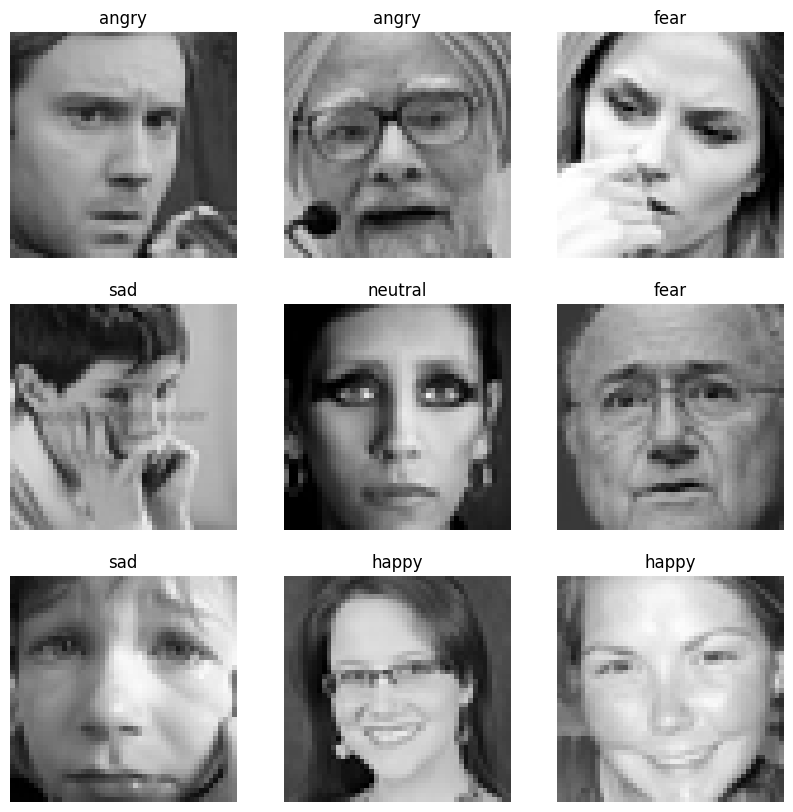

In [ ]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_title(f"{emotions_names[np.argmax(emotions[i])]}")
    ax.imshow(faces[i].astype('uint8'))
    ax.axis('off')

### Train/Test Split
As in the original dataset, we will reserve the first 28,709 images for training and the rest for testing.

In [ ]:
train_faces, train_emotions =  faces[:28709], emotions[:28709]
test_faces, test_emotions =  faces[28709:], emotions[28709:]

train_faces.shape, train_emotions.shape, test_faces.shape, test_emotions.shape

((28709, 48, 48, 3), (28709, 7), (7178, 48, 48, 3), (7178, 7))

# Problem 1: Base Model [30 Points]
In this problem, we will build a simple CNN with three convolutional blocks, one dense layer and one output layer.



## Part (a): Building the Model [10 points]
We would like to build a CNN with the following model summary. Fill in the code in the cell below so that the output of `model.summary()` matches that of the image above. Be sure to use relu activation for each of the Conv2D layers and the appropriate activation function for the output layer.


![](https://dl.dropbox.com/scl/fi/lrmaupoa243xrrsfj3qiy/cnn_model.PNG?rlkey=n5axqin6vx652qrgduyosg0pc&dl=0)

In [ ]:
input = keras.Input(shape=(48, 48, 3), name="input")

# Rescaling
h = keras.layers.Rescaling(1./255, name="rescaling_1")(input)

# Conv 1
h = keras.layers.Conv2D(16, kernel_size=(2, 2), activation="relu", name="Conv_1")(h)

# pooling layer
h = keras.layers.MaxPool2D()(h)

# Conv 2
h = keras.layers.Conv2D(16, kernel_size=(2, 2), activation="relu", name="Conv_2")(h)

# pooling layer
h = keras.layers.MaxPool2D()(h)

# Conv 3
h = keras.layers.Conv2D(16, kernel_size=(2, 2), activation="relu", name="Conv_3")(h)

# pooling layer
h = keras.layers.MaxPool2D()(h)

# Flatten Everything
h = keras.layers.Flatten()(h)

#Run through the Dense Layer
h = keras.layers.Dense(256, activation='relu')(h)
output = keras.layers.Dense(7, activation="softmax", name="output")(h)

model = keras.Model(input, output, name='CNN_model')
model.summary()

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 Conv_1 (Conv2D)             (None, 47, 47, 16)        208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 16)        0         
 D)                                                              
                                                                 
 Conv_2 (Conv2D)             (None, 22, 22, 16)        1040      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 16)        0         
 g2D)                                                    

## Part (b): Number of Parameters [10 points]
The model above has $106,743$ trainable parameters and is computed by $208 + 1040 + 1040 + 102656 + 1799$. Explain how each of these 5 numbers is calculated and show your computations (e.g. 208 = 16 * 3 * 4 + 16).


<font color='red'>Each of the numbers represent the parameter of each Layer: <br> - Conv 1: (dim of the kernels) * (number of kernels)+ (bias)<br> || : (2 * 2 * 3) * 16 * 3 + 16 = 208 <br> - Conv 2 & 3: (dim of the kernels) * (number of kernels) + (bias) <br> || : (2 * 2 * 16) * 16 + 16 = 1040 <br> - Dense: (number of weights after flatten) * (number of relu) + (bias) <br> || : 400 * 256 + 256 = 102656. The 400 is calculated by multiplying the output after the last pooling (5 * 5 * 16) <br> - Output: (number of relu before) * (number of softmax) + (bias) <br> || : 256 * 7 + 7 = 1799 </font>

## Part (c): Training and Evaluation [10 points]

Let us compile our model and fit it on the training data. Since we one-hot-encoded the dependent variable, we use `categorical_crossentropy`, not `sparse_categorical_crossentropy`.

Fill in the parameters of `model.compile` and `model.fit` below.

* Compile the model using the `categorical_crossentropy` loss, `adam` optimizer and report the `accuracy` metric.
* Fit the model on `train_faces`, `train_emotions` using a batch size of 64, for 30 epochs and a validation split of 20%.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_history = model.fit(
  train_faces, train_emotions,
  batch_size=64,
  epochs=30,
  validation_split = 0.2)

Epoch 1/30
359/359 [==============================] - 13s 31ms/step - loss: 1.7363 - accuracy: 0.2970 - val_loss: 1.6430 - val_accuracy: 0.3715
Epoch 2/30
359/359 [==============================] - 11s 30ms/step - loss: 1.5700 - accuracy: 0.3925 - val_loss: 1.5220 - val_accuracy: 0.4176
Epoch 3/30
359/359 [==============================] - 10s 29ms/step - loss: 1.4909 - accuracy: 0.4242 - val_loss: 1.4654 - val_accuracy: 0.4286
Epoch 4/30
359/359 [==============================] - 10s 29ms/step - loss: 1.4243 - accuracy: 0.4533 - val_loss: 1.3991 - val_accuracy: 0.4626
Epoch 5/30
359/359 [==============================] - 10s 29ms/step - loss: 1.3738 - accuracy: 0.4722 - val_loss: 1.3894 - val_accuracy: 0.4742
Epoch 6/30
359/359 [==============================] - 10s 29ms/step - loss: 1.3328 - accuracy: 0.4913 - val_loss: 1.3713 - val_accuracy: 0.4775
Epoch 7/30
359/359 [==============================] - 10s 28ms/step - loss: 1.2872 - accuracy: 0.5101 - val_loss: 1.3464 - val_accuracy:

**Epochs and Batches.**

In your own words, please explain the relationship between an epoch and a batch in stochastic gradient descent.

<font color='red'> In order to understand, it's better to know the process. First, when we have large data, we separate the data into mini-arrays of data. These are called mini-batches. Then, the gradient descent algorithm will pick the first batch and find the best "direction" to move in order to reduce the average loss function. That direction is called the gradient, and each time it passes a batch, it will adjust all the parameters (106,743 in this case) based on a proportion of that "loss-reduction direction." Then, it will pick the next batch, starting with the just-modified parameters, and repeat the process. This continues for each subsequent batch until it runs through the entire dataset. When it completes a full pass, it's called an Epoch.
<br>
So, basically, the batch is like taking a step towards the optimal point, and the epoch is one lap on the track. To reach the best optimal point, we need to run a marathon (that's why we have multiple "laps").</font>






When we ran `model.fit`, we saw that there are 359 batches per epoch. Please explain how this 359 is calculated. _Hint_: There are 28,709 training data points and 20% is set aside for validation.

<font color='red'>The batch size is 64 and we are using 80% to train. 80% of 28,709 is 22,967, and divided by 64 is 358.8. This mean that we have 358 batches of 64 and one last batch slighly smaller than 64 datapoints.</font>



**Plotting the Training/Validation Accuracy Curve**

Use the `plot_accuracy` function below to plot the training and validation accuracy across the training epochs.

In [ ]:
def plot_accuracy(model_history):
    history_dict = model_history.history
    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, "bo", label="Training Accuracy", linewidth=3)
    plt.plot(epochs, val_acc, "b", label="Validation Accuracy", linewidth=3)
    plt.title("Training and Validation Accuracy Across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_accuracy(model_history)

**Model Accuracy**

Calculate the accuracy on the test set. Write your code below to show the accuracy.

In [ ]:
model.evaluate(test_faces, test_emotions)

# Problem 2: Wider and Deeper Models [30 Points]
In this problem, we will modify the model from Problem 1 in two ways:
* Increase the width of the model by adding more filters and more neurons in the dense layer.
* Increase the depth of the model by adding another dense layer.

### Part (a): Wider Model [5 points]
Take the `model` from Problem 1 and modify it into `wider_model` by using 32 filters for the convolution layers instead of 16.


Write your new code below and verify that `wider_model.summary()` looks correct. Your model should have 215,527 parameters.



In [ ]:
input = keras.Input(shape=train_faces.shape[1:])

# Rescaling
h = keras.layers.Rescaling(1./255, name="rescaling_1")(input)

# Conv 1
h = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_1")(h)

# pooling layer
h = keras.layers.MaxPool2D()(h)

# Conv 2
h = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_2")(h)

# pooling layer
h = keras.layers.MaxPool2D()(h)

# Conv 3
h = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_3")(h)

# pooling layer
h = keras.layers.MaxPool2D()(h)

# Flatten Everything
h = keras.layers.Flatten()(h)

#Run through the Dense Layer
h = keras.layers.Dense(256, activation='relu')(h)
output = keras.layers.Dense(7, activation="softmax", name="output")(h)

wider_model = keras.Model(input, output, name='wider_cnn')
wider_model.summary()

## Part (b): Number of Parameters [5 points]
The model above has $215,527$ trainable parameters and is computed by $416 + 4128 + 4128 + 205056 + 1799$. Explain how each of these 5 numbers is calculated and show your computations.

<font color='red'>Each of the numbers represent the parameter of each Layer: <br> - Conv 1: (dim of the kernels) * (number of kernels)+ (bias)<br> || : (2 * 2 * 3) * 32  + 32 = 416 <br> - Conv 2 & 3: (dim of the kernels) * (number of kernels) + (bias) <br> || : (2 * 2 * 32) * 32 + 32 = 4128 <br> - Dense: (number of weights after flatten) * (number of relu) + (bias) <br> || : 800 * 256 + 256 = 205056. The 800 is calculated by multiplying the output after the last pooling (5 * 5 * 32)<br> - Output: (number of relu before) * (number of softmax) + (bias) <br> || : 256 * 7 + 7 = 1799 </font>

## Part (c): Training and Evaluation [5 points]
Let's train our model and evaluate its performance.

In [ ]:
wider_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

wider_model_history = wider_model.fit(
    train_faces, train_emotions,
    batch_size=64,
    epochs=30,
    validation_split = 0.2
)

In [ ]:
plot_accuracy(wider_model_history)

In [ ]:
wider_model.evaluate(test_faces,test_emotions)

Compare the accuracy curve of `wider_model` to that of `model` from Problem 1. Which shows more evidence of overfitting after 30 epochs? Does that make sense?

<font color='red'> The wider model have a slighly overfitting evidence. We can see that the accuracy goes to a peak arround batch 10 and then slightly goes down, with a training accuracy of 97% vs the other model that have 87%. </font>

## Part (d): Deeper Model [5 Points]
Now, build a new model called `deep_model` by taking `model` from Problem 1 and add an additional dense layer of 256 nodes immediately after the original dense layer of 256 nodes. The new model should have a total of 2 dense layers of 256 nodes each and have a total of 172,535 parameters.

Train the model, plot its accuracy vs epochs using the `plot_accuracy` function, and report the model's accuracy on the test set.

In [ ]:
input = keras.Input(shape=train_faces.shape[1:])

# Rescaling
h = keras.layers.Rescaling(1./255, name="rescaling_1")(input)

# Conv 1
h = keras.layers.Conv2D(16, kernel_size=(2, 2), activation="relu", name="Conv_1")(h)

# pooling layer
h = keras.layers.MaxPool2D()(h)

# Conv 2
h = keras.layers.Conv2D(16, kernel_size=(2, 2), activation="relu", name="Conv_2")(h)

# pooling layer
h = keras.layers.MaxPool2D()(h)

# Conv 3
h = keras.layers.Conv2D(16, kernel_size=(2, 2), activation="relu", name="Conv_3")(h)

# pooling layer
h = keras.layers.MaxPool2D()(h)

# Flatten Everything
h = keras.layers.Flatten()(h)

#Run through the Dense Layer
h = keras.layers.Dense(256, activation='relu')(h)
h = keras.layers.Dense(256, activation='relu')(h)

output = keras.layers.Dense(7, activation="softmax", name="output")(h)

deeper_model = keras.Model(input, output, name='deeper_cnn')
deeper_model.summary()

In [ ]:
deeper_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

deeper_model_history = deeper_model.fit(
  train_faces, train_emotions,
  batch_size=64,
  epochs=30,
  validation_split = 0.2
)

In [ ]:
plot_accuracy(deeper_model_history)

In [ ]:
deeper_model.evaluate(test_faces, test_emotions)

## Part (e): Comparison [10 points]
Comment on the difference between the test accuracy of `model`, `wider_model` and `deeper_model`. Did widening the model or deepening the model result in a better performance? Why? Do you think
this result generally holds true for all problems?

<font color='red'>**Your Answer**</font>

Test Accuracy Comparison:
* `model`: 0.00%
* `wider_model`: 0.00%
* `deeper_model`: 0.00%

_Please fill in the numbers above and replace this text with your response._

# Problem 3: Data Augmentation [15 Points]

The basic idea of augmentation is to alter the image so slightly that the value of the dependent variable (i.e. the category that it belongs to) doesn't change.

Keras allows us to easily perform data augmentation using layers such as:

* `keras.layers.RandomFlip`
* `keras.layers.RandomZoom`
* `keras.layers.RandomRotation`

Lets quickly visualize what the augmentation does ... Here, we flip the images horizontally, then apply a random zoom of up to 20%. Note that you do not need to understand how the code below works. Most of it is there to allow us to visualize the augmentation.

In [ ]:
def augment_images(image):
    x = keras.layers.RandomFlip("horizontal")(image)
    x = keras.layers.RandomZoom(0.2)(x)
    return x

augmented_images = [augment_images(np.expand_dims(train_faces[0],axis=0)) for i in range(9)]
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    ax.imshow(tf.keras.preprocessing.image.array_to_img(augmented_images[i][0]), cmap='gray', vmin=0, vmax=255)

We take our model `wider_model` from Problem 2(c) and add a random flip and random zoom as **layers** before the rescaling layer.

In [ ]:
input = keras.Input(shape=(48, 48, 3))

### DATA AUGMENTATION ###
x = keras.layers.RandomFlip("horizontal")(input)
x = keras.layers.RandomZoom(0.2)(x)

### YOUR CODE HERE ###
# Please insert your code from wider_model here.

model_augmented = keras.Model(input, output, name='augmented_CNN_model')
model_augmented.summary()

Train the model (using the same parameters as all previous questions), show the accuracy vs. epoch curve, and report the accuracy on the test set.

In [ ]:
model_augmented.compile(
    ### YOUR CODE HERE ###
)

model_augmented_history = model_augmented.fit(
    ### YOUR CODE HERE ###
)

In [ ]:
plot_accuracy(model_augmented_history)

In [ ]:
# Calculate the test accuracy
### YOUR CODE HERE ###
deeper_model.evaluate(test_faces, test_emotions)

Compare this with `wider_model` and comment on the impact of data augmentation.

* Did data augmentation reduce overfitting?
* Did data augmentation improve test set accuracy

<font color='red'> **Your Answer.** </font>

_Please replace this text with your answer_

# Problem 4: Transfer Learning and Fine-Tuning [25 points]

Next, we apply transfer learning to our problem using VGG19, a pre-trained model similar to ResNet50 from class. We will take VGG19 and make it "headless", then run it through our own "little" NN.

We will take three different approaches to this:

1. Part (a): **Base Transfer Learning**. Fix the weights from headless VGG19 and learn the weights on the little NN.
2. Part (b): **Some fine-tuning** Fix the weights on the top 6 out of 19 layers of VGG19, but allow the weights from the remaining 13 layers to be optimized by SGD/Adam, in addition to those of the little NN.
3. Part (c): **Fine-Tuning** Allow all weights in VGG19 to be tuned, in addition to the little NN.

For each of the models, we will plot their train/validation accuracy curve, compute their test accuracy, and compute a confusion matrix.

## Part (a): No Fine Tuning [5 Points]

Let us fetch the VGG19 model, making sure to set `include_top=False` so that we do not take its output layer. We also set `trainable=False` to indicate that the parameters in these 19 layers are not trainable.



In [ ]:
base_model = keras.applications.VGG19(
    include_top=False,   # this makes VGG19 headless
    weights="imagenet",
    input_tensor=None,
    input_shape=(48, 48, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

# Freeze the base_model so that it is not trainable at all
base_model.trainable = False

We build a neural network that performs data augmentation and rescaling, then uses the VGG19, and finally has one dense layer before the output layer.

In [ ]:
inputs = keras.Input(shape=(48,48,3))

x = keras.layers.RandomFlip("horizontal")(inputs)
x = keras.layers.RandomZoom(0.2)(x)
x = keras.layers.Rescaling(1./255)(x) # normalizing

# Add layers from base_model one at a time
for layer in base_model.layers:
    x = layer(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(7, activation='softmax')(x)

transfer_model = keras.Model(inputs, outputs, name='transfer_model')
transfer_model.summary()

Train the model. Here, we use a learning rate of 0.00002 to get better convergence.

In [ ]:
transfer_model.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(2e-5),
            metrics=['accuracy'])

transfer_model_history = transfer_model.fit(train_faces, train_emotions, epochs=30, validation_split=0.2)

We can plot the training and validation accuracy curve.

In [ ]:
plot_accuracy(transfer_model_history)

Let's also calculate the confusion matrix and the accuracy on the test set.

The function `show_confusion_matrix` has been written for you below. You can apply it to any Keras Model and it will calculate:
* Test accuracy
* A confusion matrix. Recall that each row of the confusion matrix are the actual labels and each column are the predictions. For example, if element in row `happy` and column `sad` is 250, then there are 250 data points in the test set where the true label is `happy` but we predicted `sad`.
* A heatmap of the confusion matrix, where each row is normalized to add up to 1.0. For example, if element in row `happy` and column `sad` is 0.25, then that means 25% of data points with a true label of `happy` were predicted as `sad`.

In [ ]:
from IPython.display import display

def show_confusion_matrix(model):
    """
    Calculates the test accuracy, confusion matrix and heat map for a model.
    """
    global test_faces, test_emotions, emotions_names

    y_pred = model.predict(test_faces).argmax(axis=1)
    y_actual = test_emotions.argmax(axis=1)

    print('*************************\n* Test Accuracy: %.4f *\n*************************' % metrics.accuracy_score(y_actual, y_pred))

    cm = pd.DataFrame(metrics.confusion_matrix(y_actual, y_pred), index=emotions_names, columns=emotions_names)
    display(cm)

    cm = cm.div(cm.sum(axis=1), axis=0)

    sns.heatmap(cm, cmap="Blues", annot=True, fmt=".2f")

show_confusion_matrix(transfer_model)

Please comment briefly on the model's performance.

<font color='red'> **Your Answer** </font>

_Please replace this text with your answer_

## Part (b): Some Fine Tuning [5 Points]
In this part, we will allow our optimization model to tune **some** of the layers from VGG19. In particular, we will only freeze the first 15 layers and allow the remaining layers to be trained.


In [ ]:
base_model = keras.applications.VGG19(
    include_top=False,   # this makes VGG19 headless
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

inputs = keras.Input(shape=(48,48,3))

x = keras.layers.RandomFlip("horizontal")(inputs)
x = keras.layers.RandomZoom(0.2)(x)
x = keras.layers.Rescaling(1./255)(x) # normalizing

# Add layers from base_model
for layer in base_model.layers:
    x = layer(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(7, activation='softmax')(x)

partial_model = keras.Model(inputs, outputs, name='partial_fine_tune_model')

# Make the first 15 layers not trainable. All other layers are trainable
for layer in partial_model.layers[:15]:
    layer.trainable = False

partial_model.summary()

Let's see which layers are trainable. Notice that VGG19 consists of 4 blocks of convolution filters (block1_conv1, block1_conv2, ..., block5_conv4). We are allowing block4 and block5 to be trained and freezing blocks 1, 2 and 3.

In [ ]:
for i, layer in enumerate(partial_model.layers):
    print('Layer %d: %s (%s), Trainable=%s' % (i+1, layer.name, layer.__class__.__name__, layer.trainable))

Train the model and examine its train/validation curve, test accuracy and confusion matrix.

In [ ]:
partial_model.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(2e-5),
            metrics=['accuracy'])

partial_model_history = partial_model.fit(train_faces, train_emotions, epochs=30, validation_split=0.2)

In [ ]:
plot_accuracy(partial_model_history)

In [ ]:
show_confusion_matrix(partial_model)

Please comment briefly on the model's performance.  

<font color='red'> **Your Answer** </font>

_Please replace this text with your answer_

## Part (c): Fine Tuning [5 Points]
Now, let's try a transfer learning model where all layers can be fine tuned.

In [ ]:
base_model = keras.applications.VGG19(
    include_top=False,   # this makes VGG19 headless
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

inputs = keras.Input(shape=(48,48,3))

x = keras.layers.RandomFlip("horizontal")(inputs)
x = keras.layers.RandomZoom(0.2)(x)
x = keras.layers.Rescaling(1./255)(x) # normalizing

# Add layers from base_model
for layer in base_model.layers:
    x = layer(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(7, activation='softmax')(x)

tuned_model = keras.Model(inputs, outputs, name='full_fine_tune_model')

# Let's see which layers are trainable
for i, layer in enumerate(tuned_model.layers):
    print('Layer %d: %s (%s), Trainable=%s' % (i+1, layer.name, layer.__class__.__name__, layer.trainable))

In [ ]:
tuned_model.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(2e-5),
            metrics=['accuracy'])

tuned_model_history = tuned_model.fit(train_faces, train_emotions, epochs=30, validation_split=0.2)

In [ ]:
plot_accuracy(tuned_model_history)

In [ ]:
show_confusion_matrix(tuned_model)

Please comment briefly on the model's performance.  

<font color='red'> **Your Answer** </font>

_Please replace this text with your answer_

## Part (d): Comparison [10 Points]

Please fill in the table below with the test accuracies of the three models above, as well as that of `wider_model` from Problem 2.

<font color='red'>**Your Answer.**</font>

Model Test Accuracy:
* Model (a) with no fine tuning: 0.00%
* Model (b) with some fine tuning: 0.00%
* Model (c) with fine tuning: 0.00%
* `wider_model` from Problem 2(a)-(c): 0.00%


Comment on the performance of Models (a), (b) and (c). In particular, please address the following questions:

* Why do models (b) and (c) perform so much better than `wider_model`?
* Why do you think Model (a) performs so poorly?
* Why do you think Model (c) performs better than model (b)?

<font color='red'>**Your Answer.**</font>

_Please replace this text with your answer_